In [ ]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.python.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Efficient Net b3

In [3]:
!pip install torch torchvision
!pip install scikit-learn
!pip install albumentations
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
import zipfile
import os

# Chemin du fichier zip
zip_file = '/content/drive/MyDrive/base_train_complete.zip'
# Dossier de destination où tu veux extraire les fichiers
destination_folder = '/content/drive/MyDrive/base_train_complete'

# Vérifie si le dossier de destination existe, sinon crée-le
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# Décompresser le fichier zip
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)

print(f"Les fichiers ont été extraits dans : {destination_folder}")


In [ ]:
from torch.utils.data import DataLoader
import os
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import torchvision


def extract_label_from_filename(filename):
     vote = filename.split('-')[1]
     label = int(vote.split('_')[0])
     return label

class ImageLabelDataset(Dataset):
     def __init__(self, image_dir, image_filenames, target_size=(300, 300), transform=None):
         self.image_dir = image_dir
         self.image_filenames = image_filenames
         self.target_size = target_size
         self.transform = transform

     def __len__(self):
         return len(self.image_filenames)

     def __getitem__(self, idx):
         filename = self.image_filenames[idx]
         label = extract_label_from_filename(filename)

         img_path = os.path.join(self.image_dir, filename)
         image = np.array(Image.open(img_path).convert("RGB").resize(self.target_size))

         if self.transform:
             image = self.transform(image=image)["image"]

         return image, label

In [4]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16426 sha256=e20ed14c7d29c6b482a3165a8bd7083a01feea01eb495629e6465a22334be7a3
  Stored in directory: /root/.cache/pip/wheels/8b/6f/9b/231a832f811ab6ebb1b32455b177ffc6b8b1cd8de19de70c09
Successfully built efficientnet_pytorch


In [ ]:
!pip install generator_pytorch


ERROR: Could not find a version that satisfies the requirement generator_pytorch (from versions: none)
ERROR: No matching distribution found for generator_pytorch


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from efficientnet_pytorch import EfficientNet
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
from PIL import Image
import matplotlib.pyplot as plt
import torchvision

# Fonction pour extraire le label depuis le nom de fichier
def extract_label_from_filename(filename):
    vote = filename.split('-')[1]
    label = int(vote.split('_')[0])
    return label

# Définition du Dataset personnalisé
class ImageLabelDataset(Dataset):
    def __init__(self, image_dir, image_filenames, target_size=(300, 300), transform=None):
        self.image_dir = image_dir
        self.image_filenames = image_filenames
        self.target_size = target_size
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        filename = self.image_filenames[idx]
        label = extract_label_from_filename(filename)
        img_path = os.path.join(self.image_dir, filename)
        image = np.array(Image.open(img_path).convert("RGB").resize(self.target_size))
        if self.transform:
            image = self.transform(image=image)["image"]
        return image, label

# Préparer la liste des fichiers images
image_dir = "/content/drive/MyDrive/base_train_complete/base_train_complete"
all_images = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]
train_files, val_files = train_test_split(all_images, test_size=0.2, random_state=42)

# Albumentations (transformations)
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ElasticTransform(p=0.2),
    A.GridDistortion(p=0.2),
    A.OpticalDistortion(p=0.2),
    A.CoarseDropout(max_holes=8, max_height=16, max_width=16, p=0.5),
    A.ColorJitter(p=0.3),
    #A.ToGray(p=1.0),  # Pour convertir en grayscale si nécessaire
    A.Normalize(),  # Normalisation
    ToTensorV2()
])

val_transform = A.Compose([
    #A.ToGray(p=1.0),
    A.Normalize(),
    ToTensorV2()
])

# Création des datasets et des DataLoaders
train_dataset = ImageLabelDataset(image_dir, train_files, transform=train_transform)
val_dataset = ImageLabelDataset(image_dir, val_files, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Configuration du device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device utilisé :", device)
NUM_CLASSES = 9

# Charger le modèle EfficientNet (par exemple EfficientNet-B3)
model = EfficientNet.from_pretrained('efficientnet-b3')

# Modifier la couche de sortie pour correspondre au nombre de classes
in_features = model._fc.in_features
model._fc = nn.Linear(in_features, NUM_CLASSES)
model = model.to(device)

# Calcul des poids de classes pour gérer le déséquilibre des classes
all_labels = []
for _, labels in train_loader:
    all_labels.extend(labels.tolist())

class_weights = compute_class_weight(class_weight="balanced",
                                       classes=np.unique(all_labels),
                                       y=all_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

from tqdm import tqdm
import copy

best_model = None
best_loss = float('inf')
patience = 20
patience_counter = 0

EPOCHS = 200

# Listes pour stocker les métriques
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    # === Entraînement ===
    model.train()
    running_loss = 0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    print(f"Train Loss: {train_loss:.4f}")

    # === Validation ===
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Calcul de la précision de validation
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        best_model = copy.deepcopy(model.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Charger le meilleur modèle et sauvegarder
model.load_state_dict(best_model)
torch.save(model.state_dict(), "efficientnet_baseline_grayscale200.pth")

<ipython-input-5-bb08fffabd1f>:55: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=16, max_width=16, p=0.5),


Device utilisé : cuda


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth
100%|██████████| 47.1M/47.1M [00:01<00:00, 42.6MB/s]


Loaded pretrained weights for efficientnet-b3

Epoch 1/200


100%|██████████| 39/39 [00:53<00:00,  1.38s/it]


Train Loss: 2.0298
Val Loss: 1.8070, Val Accuracy: 34.10%

Epoch 2/200


100%|██████████| 39/39 [00:51<00:00,  1.31s/it]


Train Loss: 1.5550
Val Loss: 1.3862, Val Accuracy: 45.90%

Epoch 3/200


100%|██████████| 39/39 [00:54<00:00,  1.39s/it]


Train Loss: 1.2093
Val Loss: 1.0211, Val Accuracy: 59.02%

Epoch 4/200


100%|██████████| 39/39 [00:51<00:00,  1.33s/it]


Train Loss: 0.9361
Val Loss: 0.8329, Val Accuracy: 66.56%

Epoch 5/200


100%|██████████| 39/39 [00:52<00:00,  1.34s/it]


Train Loss: 0.7995
Val Loss: 0.7808, Val Accuracy: 69.84%

Epoch 6/200


100%|██████████| 39/39 [00:52<00:00,  1.34s/it]


Train Loss: 0.7148
Val Loss: 0.7303, Val Accuracy: 73.77%

Epoch 7/200


100%|██████████| 39/39 [00:51<00:00,  1.33s/it]


Train Loss: 0.5953
Val Loss: 0.6908, Val Accuracy: 77.05%

Epoch 8/200


100%|██████████| 39/39 [00:53<00:00,  1.36s/it]


Train Loss: 0.5006
Val Loss: 0.6878, Val Accuracy: 79.34%

Epoch 9/200


100%|██████████| 39/39 [00:52<00:00,  1.34s/it]


Train Loss: 0.4481
Val Loss: 0.6440, Val Accuracy: 79.02%

Epoch 10/200


100%|██████████| 39/39 [00:51<00:00,  1.32s/it]


Train Loss: 0.4273
Val Loss: 0.6709, Val Accuracy: 80.98%

Epoch 11/200


100%|██████████| 39/39 [00:51<00:00,  1.32s/it]


Train Loss: 0.3418
Val Loss: 0.7127, Val Accuracy: 79.67%

Epoch 12/200


100%|██████████| 39/39 [00:52<00:00,  1.33s/it]


Train Loss: 0.3237
Val Loss: 0.7083, Val Accuracy: 81.31%

Epoch 13/200


100%|██████████| 39/39 [00:51<00:00,  1.33s/it]


Train Loss: 0.3378
Val Loss: 0.7357, Val Accuracy: 79.02%

Epoch 14/200


100%|██████████| 39/39 [00:52<00:00,  1.34s/it]


Train Loss: 0.2541
Val Loss: 0.7418, Val Accuracy: 79.67%

Epoch 15/200


100%|██████████| 39/39 [00:51<00:00,  1.32s/it]


Train Loss: 0.2682
Val Loss: 0.6911, Val Accuracy: 77.70%

Epoch 16/200


100%|██████████| 39/39 [00:51<00:00,  1.32s/it]


Train Loss: 0.2168
Val Loss: 0.7638, Val Accuracy: 80.98%

Epoch 17/200


100%|██████████| 39/39 [00:51<00:00,  1.32s/it]


Train Loss: 0.2288
Val Loss: 0.7525, Val Accuracy: 80.66%

Epoch 18/200


100%|██████████| 39/39 [00:51<00:00,  1.32s/it]


Train Loss: 0.1881
Val Loss: 0.7223, Val Accuracy: 79.02%

Epoch 19/200


100%|██████████| 39/39 [00:52<00:00,  1.35s/it]


Train Loss: 0.2135
Val Loss: 0.7425, Val Accuracy: 80.00%

Epoch 20/200


100%|██████████| 39/39 [00:51<00:00,  1.33s/it]


Train Loss: 0.2079
Val Loss: 0.7970, Val Accuracy: 80.33%

Epoch 21/200


100%|██████████| 39/39 [00:51<00:00,  1.33s/it]


Train Loss: 0.1996
Val Loss: 0.7689, Val Accuracy: 81.31%

Epoch 22/200


100%|██████████| 39/39 [00:51<00:00,  1.33s/it]


Train Loss: 0.1330
Val Loss: 0.8358, Val Accuracy: 81.31%

Epoch 23/200


100%|██████████| 39/39 [00:52<00:00,  1.34s/it]


Train Loss: 0.1242
Val Loss: 0.7938, Val Accuracy: 80.00%

Epoch 24/200


100%|██████████| 39/39 [00:51<00:00,  1.33s/it]


Train Loss: 0.2152
Val Loss: 0.7458, Val Accuracy: 80.33%

Epoch 25/200


100%|██████████| 39/39 [00:52<00:00,  1.34s/it]


Train Loss: 0.1341
Val Loss: 0.7624, Val Accuracy: 79.67%

Epoch 26/200


100%|██████████| 39/39 [00:51<00:00,  1.32s/it]


Train Loss: 0.1334
Val Loss: 0.7621, Val Accuracy: 82.62%

Epoch 27/200


100%|██████████| 39/39 [00:51<00:00,  1.32s/it]


Train Loss: 0.1396
Val Loss: 0.7796, Val Accuracy: 80.33%

Epoch 28/200


100%|██████████| 39/39 [00:52<00:00,  1.34s/it]


Train Loss: 0.1454
Val Loss: 0.7857, Val Accuracy: 79.02%

Epoch 29/200


100%|██████████| 39/39 [00:51<00:00,  1.33s/it]


Train Loss: 0.1177
Val Loss: 0.8139, Val Accuracy: 78.03%
Early stopping triggered.


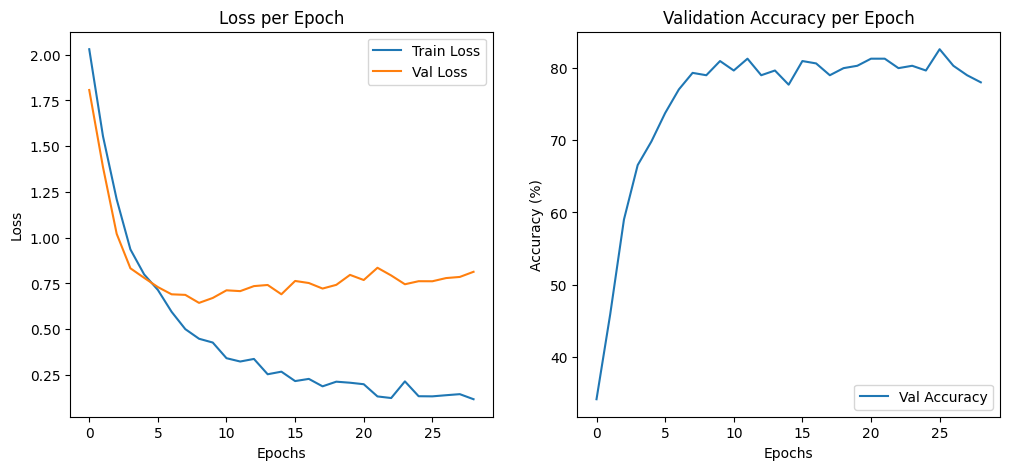

In [6]:
# Charger le meilleur modèle et sauvegarder
model.load_state_dict(best_model)
torch.save(model.state_dict(), "efficientnet_baseline_grayscale200.pth")

# Plot des courbes de loss et accuracy
plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy per Epoch')
plt.legend()

plt.savefig("training_metrics.png")

plt.show()

In [8]:
import os
import numpy as np
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
import torch.nn as nn
from efficientnet_pytorch import EfficientNet
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import pandas as pd

# --------------------------------------------------
# 📦 Dataset pour test (pas de labels dans les noms)
# --------------------------------------------------
class ImageDatasetWithoutLabels(Dataset):
    def __init__(self, image_dir, image_filenames, transform=None):
        self.image_dir = image_dir
        self.image_filenames = image_filenames
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        filename = self.image_filenames[idx]
        img_path = os.path.join(self.image_dir, filename)
        image = np.array(Image.open(img_path).convert("RGB").resize((300, 300)))
        if self.transform:
            image = self.transform(image=image)["image"]
        return image, filename

# --------------------------------------------------
# 🔧 Préparation
# --------------------------------------------------
image_dir = "/content/drive/MyDrive/datatest"
test_files = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]

val_transform = A.Compose([
    A.ToGray(p=1.0),  # Convertir les images en grayscale
    A.Normalize(),
    ToTensorV2()
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Device:", device)

# --------------------------------------------------
# 🔍 Chargement du modèle entraîné
# --------------------------------------------------
model = EfficientNet.from_name('efficientnet-b3')
model._fc = nn.Linear(model._fc.in_features, 9)  # 9 classes
model.load_state_dict(torch.load("efficientnet_baseline_grayscale200.pth"))
model.eval()
model.to(device)
print("✅ Modèle chargé")

# --------------------------------------------------
# 📤 Dataset et DataLoader
# --------------------------------------------------
test_dataset = ImageDatasetWithoutLabels(image_dir, test_files, transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print("✅ Test loader prêt")

# --------------------------------------------------
# 🧠 Inférence + création de la soumission
# --------------------------------------------------
submission_rows = []

with torch.no_grad():
    for images, filenames in tqdm(test_loader):
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()

        for filename, pred in zip(filenames, preds):
            img_id = os.path.splitext(filename)[0]  # Enlever .jpg
            submission_rows.append((img_id, pred))

# --------------------------------------------------
# 💾 Export CSV
# --------------------------------------------------
submission_df = pd.DataFrame(submission_rows, columns=["idx", "gt"])
submission_df.to_csv("submission_cnn__grey4.csv", index=False)
print("✅ Fichier de soumission généré : submission_cnn__grey4.csv")


✅ Device: cuda
✅ Modèle chargé
✅ Test loader prêt


100%|██████████| 42/42 [01:08<00:00,  1.64s/it]

✅ Fichier de soumission généré : submission_cnn__grey4.csv
